In [75]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
import tensorflow as tf
import time
import concurrent.futures
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import imgaug
from imgaug import augmenters as iaa

# Root directory of the project
ROOT_DIR = os.getcwd()
if ROOT_DIR.endswith("samples/Nucleus_Seg"):
    # Go up two levels to the repo root
    ROOT_DIR = os.path.dirname(os.path.dirname(ROOT_DIR))
    
# Import Mask RCNN
sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model as modellib
from mrcnn.config import Config
from mrcnn.model import log
from mrcnn import model

import nucleus

%matplotlib inline 
# Directory to save logs and trained model
LOGS_DIR = os.path.join(ROOT_DIR, "logs")

In [76]:
print(os.path.dirname(ROOT_DIR))
print(ROOT_DIR)
print(LOGS_DIR)

/home/naveen/v3
/home/naveen/v3/Mask_RCNN
/home/naveen/v3/Mask_RCNN/logs


In [77]:
# Dataset directory
DATASET_DIR = os.path.join(ROOT_DIR, "samples/Nucleus_Seg/Dataset")
print(DATASET_DIR)

# Inference Configuration
config = nucleus.NucleusInferenceConfig()
config.display()

/home/naveen/v3/Mask_RCNN/samples/Nucleus_Seg/Dataset

Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK

In [78]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# Only inference mode is supported right now
TEST_MODE = "inference"

In [79]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

In [80]:
# Load dataset
dataset = nucleus.NucleusDataset()
dataset.load_nucleus(DATASET_DIR, subset="stage1_test")
# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 65
Class Count: 2
  0. BG                                                
  1. nucleus                                           


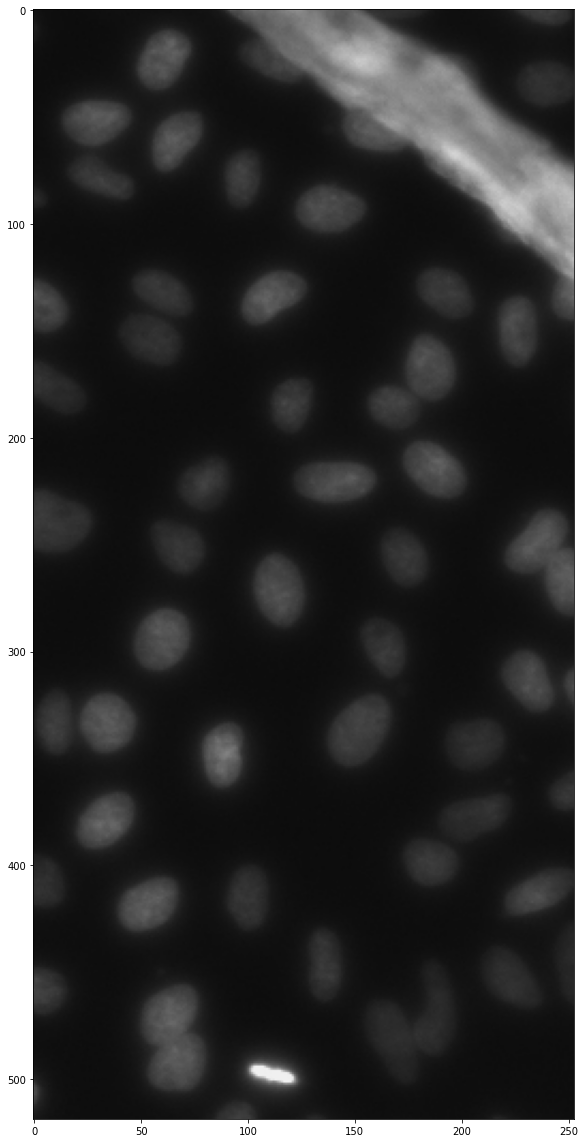

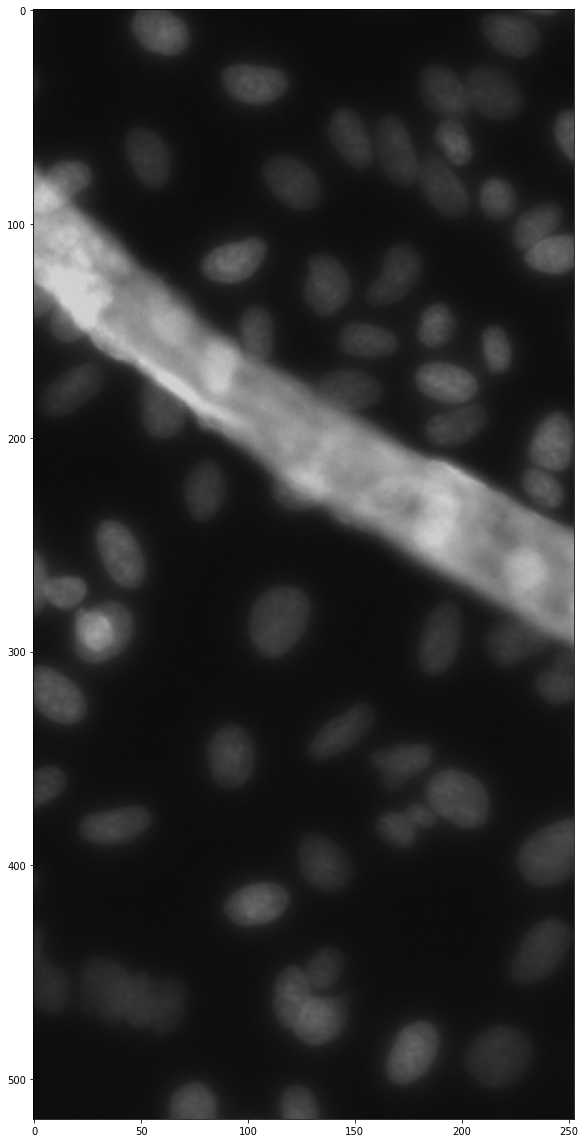

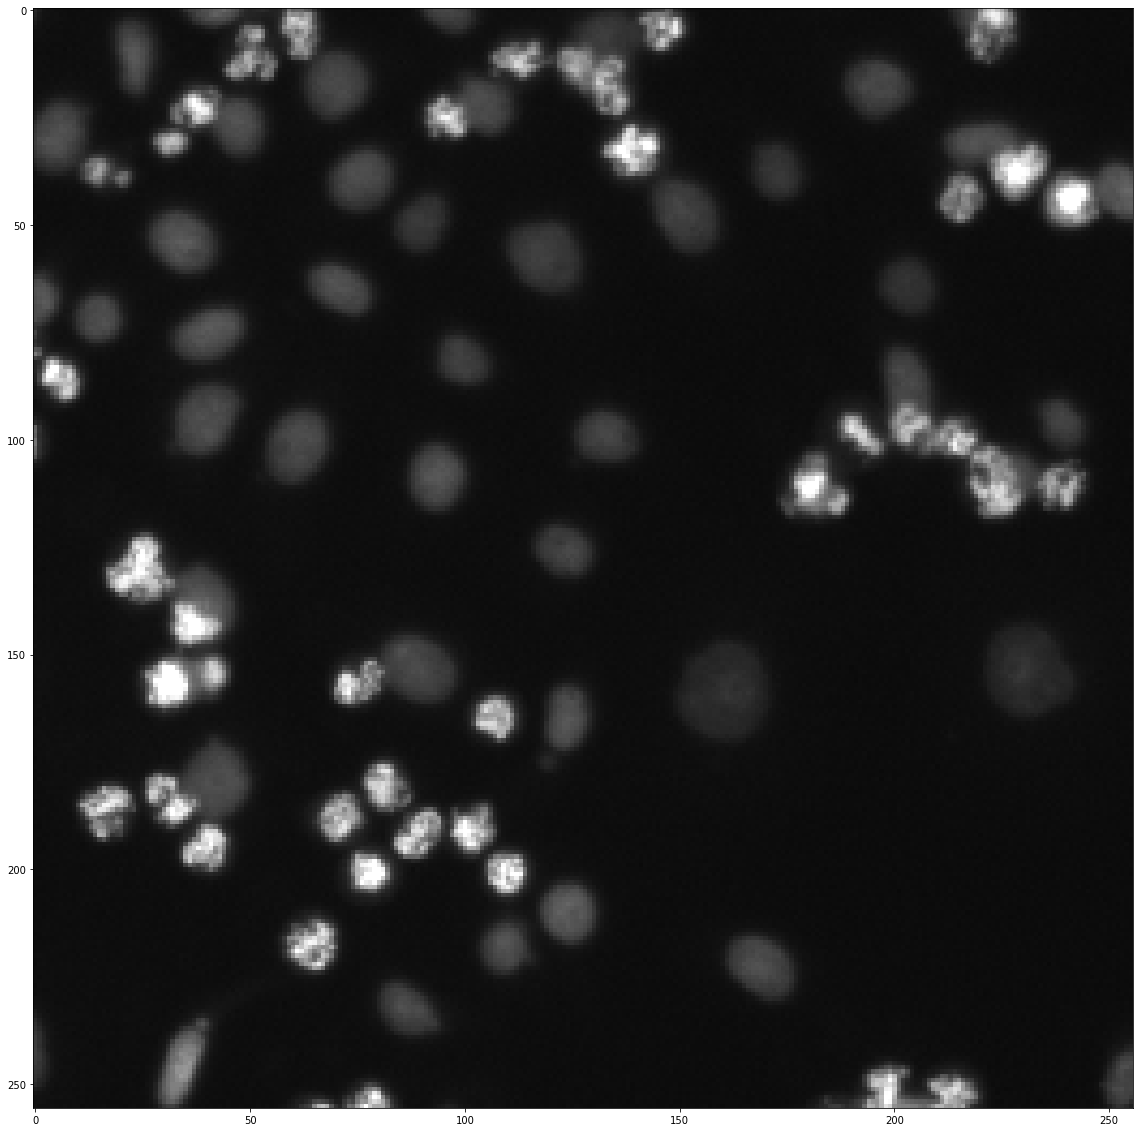

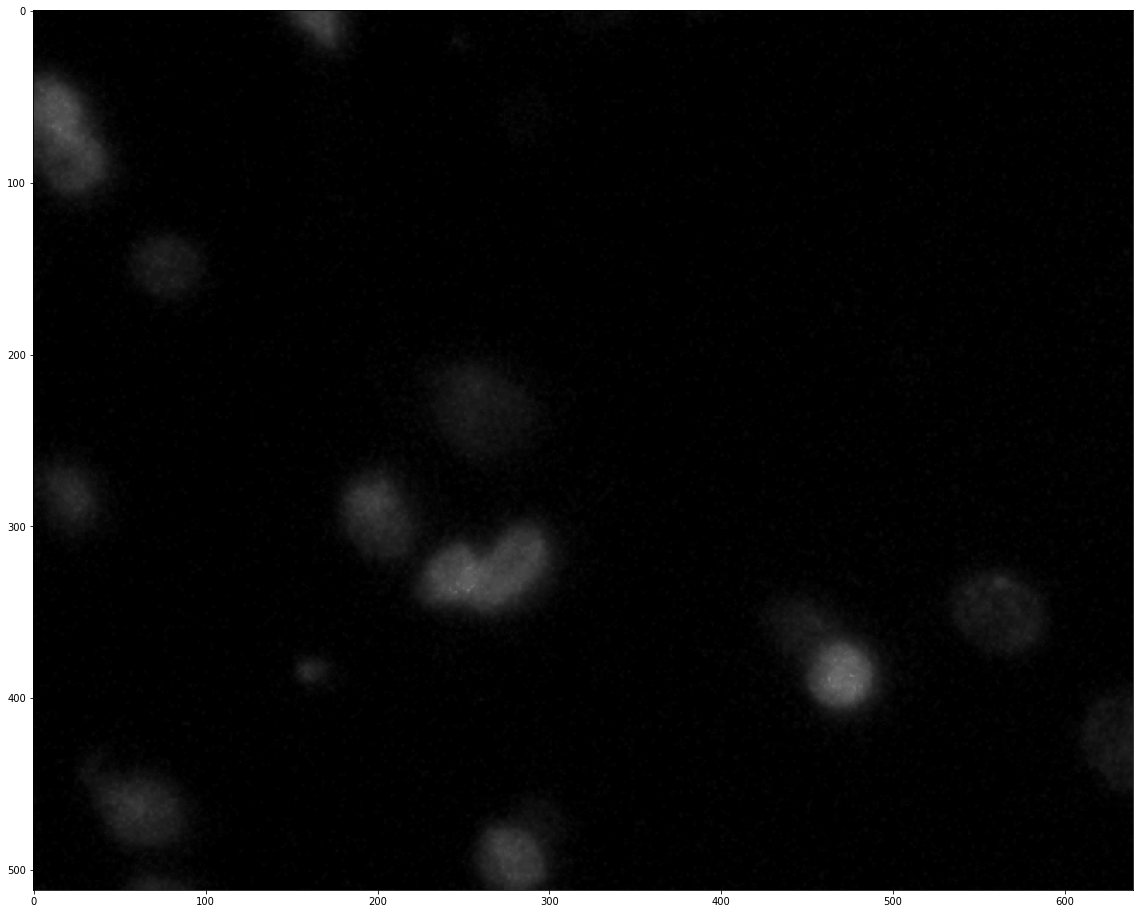

In [81]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    #mask, class_ids = dataset.load_mask(image_id)
    ax = get_ax()
    ax.imshow(image)
    

In [82]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=LOGS_DIR,
                              config=config)

In [83]:


# Path to a specific weights file
weights_path = "./mask_rcnn_nucleus_0015.h5"

# # Or, load the last model you trained
# #weights_path = model.find_last()

# # Load weights
print("Loading weights ", weights_path)
#model.load_weights(weights_path, by_name=True)
model.load_weights(weights_path, by_name=True,exclude=None)

Loading weights  ./mask_rcnn_nucleus_0015.h5


In [84]:
class_names =['BG','nucleus']

image ID: nucleus.b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65571bcb117fa8398ba3 (43) b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65571bcb117fa8398ba3
Processing 1 images
image                    shape: (512, 640, 3)         min:    0.00000  max:  126.00000  uint8
molded_images            shape: (1, 1024, 1280, 3)    min:  -48.22000  max:   80.44000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 327360, 4)        min:   -0.08847  max:    1.02591  float32


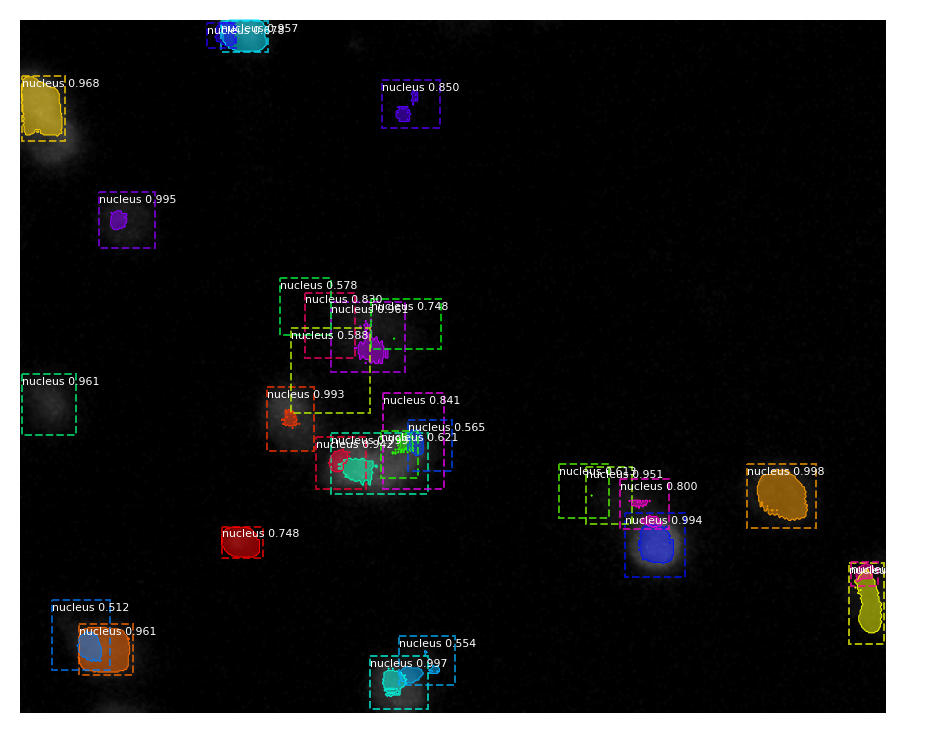

In [85]:
image_id = random.choice(dataset.image_ids)
#image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))


# # Run object detection
#results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)
# Run detection
results = model.detect([image], verbose=1)
# # Display results
r = results[0]
# Visualize results
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

(256, 256, 3)
image ID: nucleus.4727d94c6a57ed484270fdd8bbc6e3d5f2f15d5476794a4e37a40f2309a091e2 (35) 4727d94c6a57ed484270fdd8bbc6e3d5f2f15d5476794a4e37a40f2309a091e2
Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -38.22000  max:  215.44000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


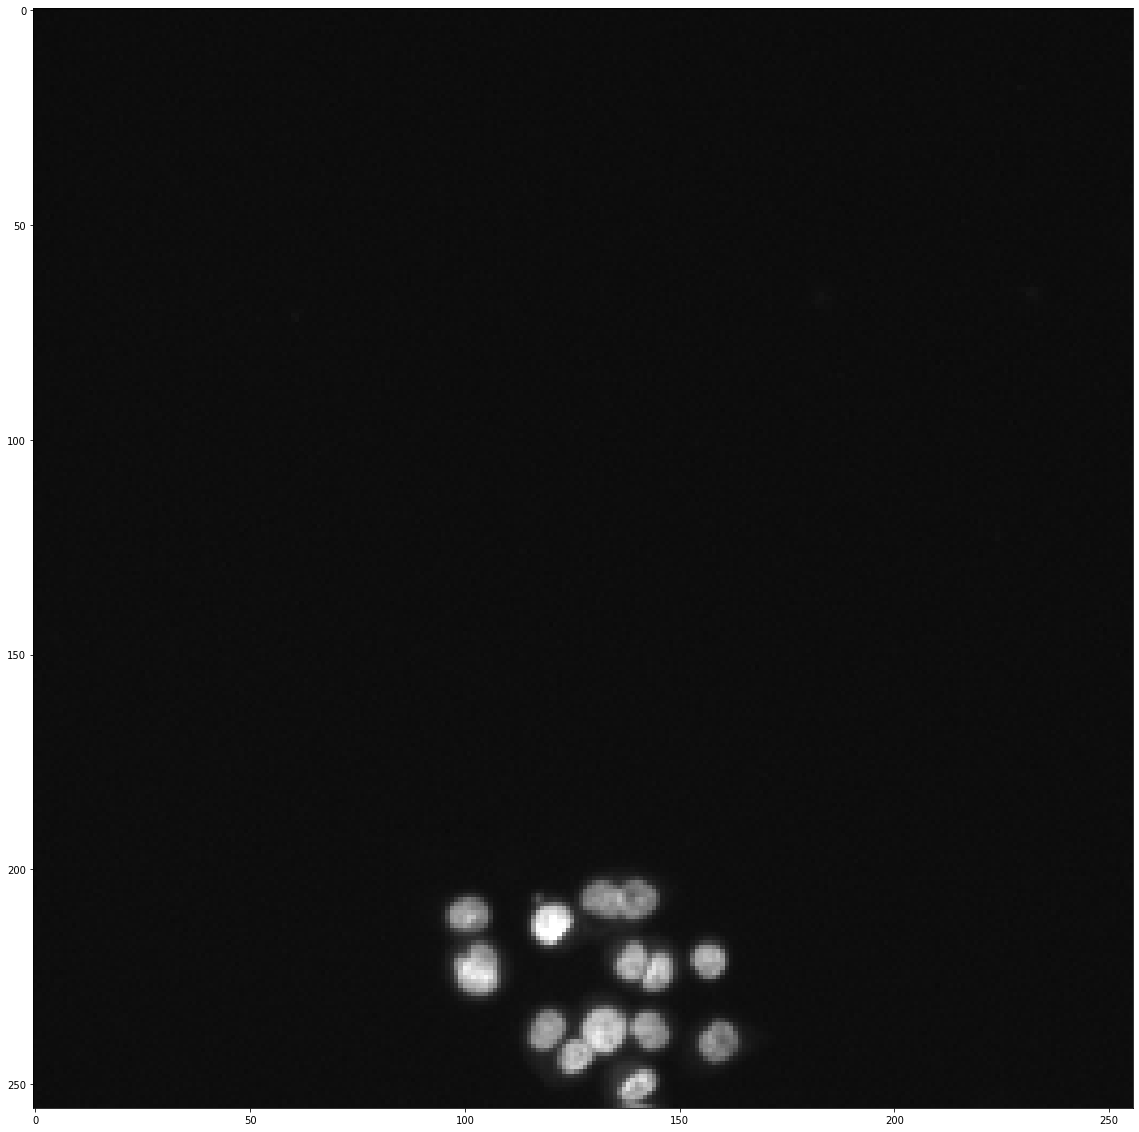

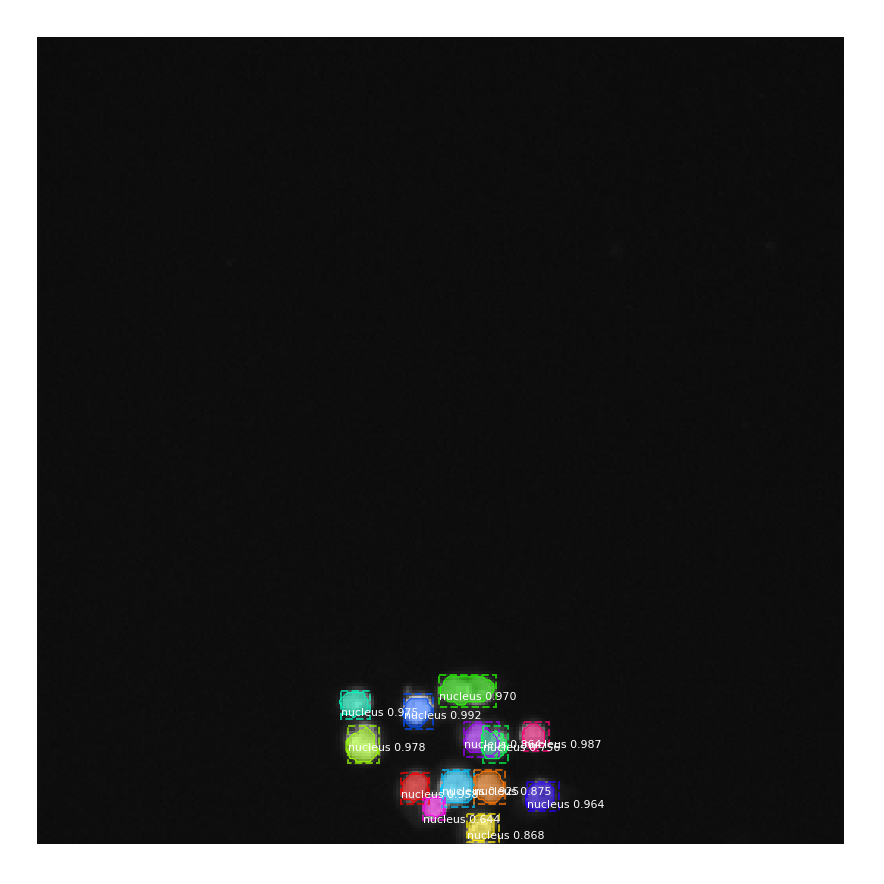

In [86]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
original_shape = image.shape
print(original_shape)
ax = get_ax()
ax.imshow(image)

info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run detection
results = model.detect([image], verbose=1)
# # Display results
r = results[0]
# Visualize results
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [87]:
mask = r['masks']
mask = mask.astype(int)
mask.shape

(256, 256, 13)

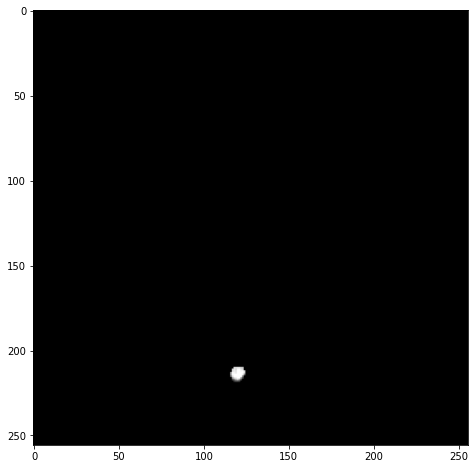

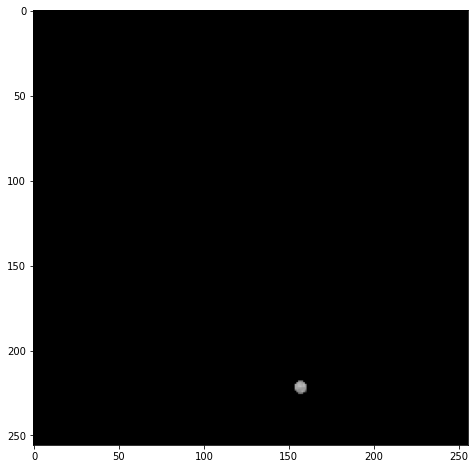

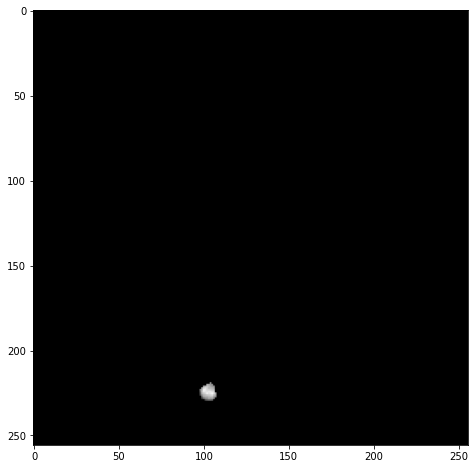

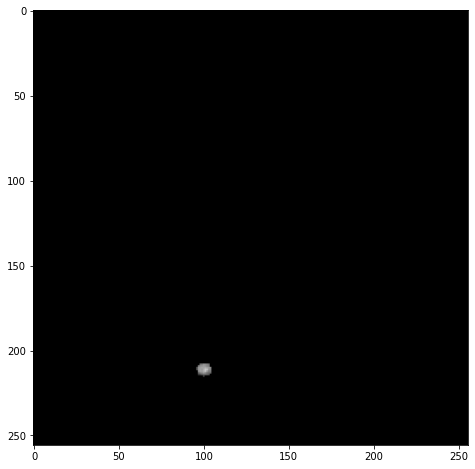

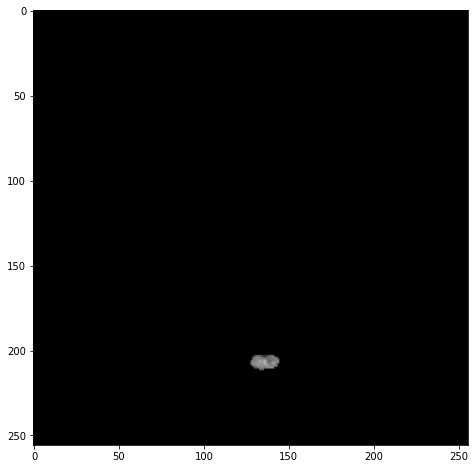

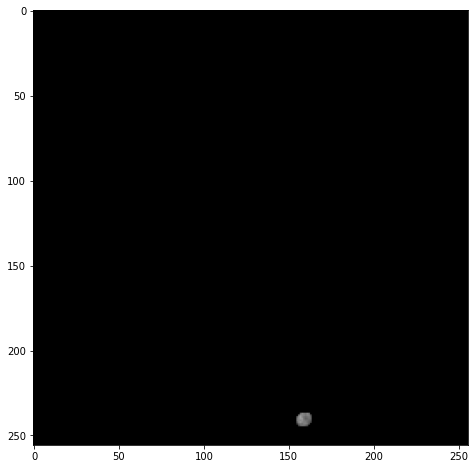

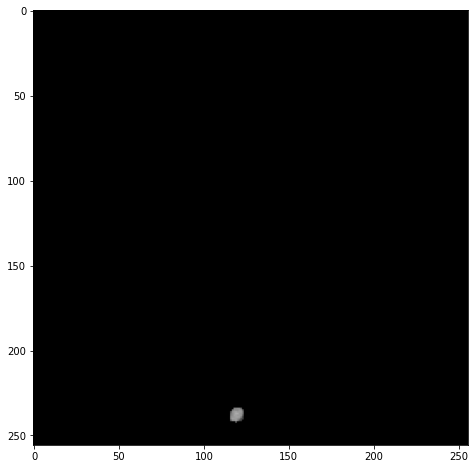

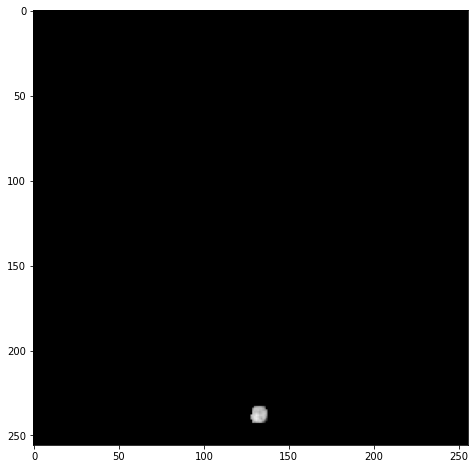

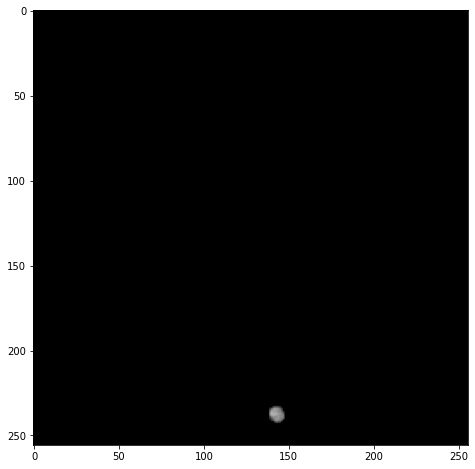

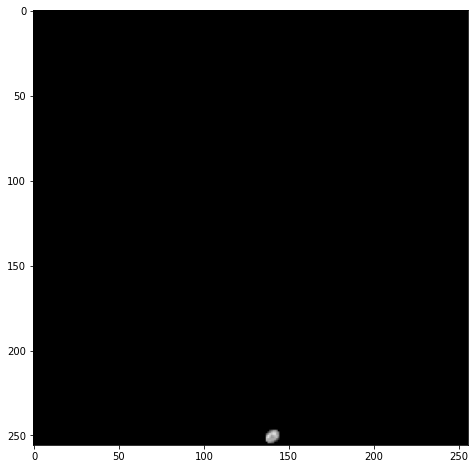

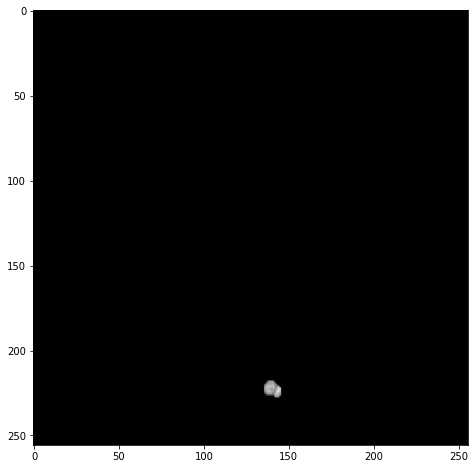

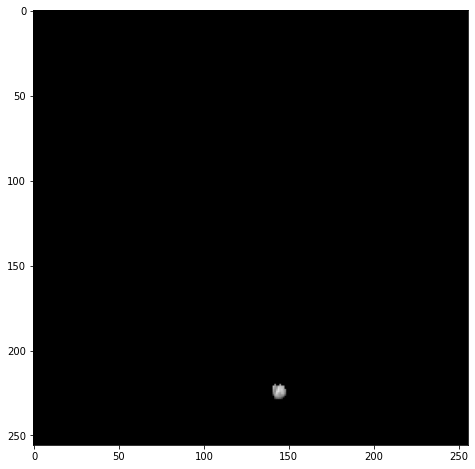

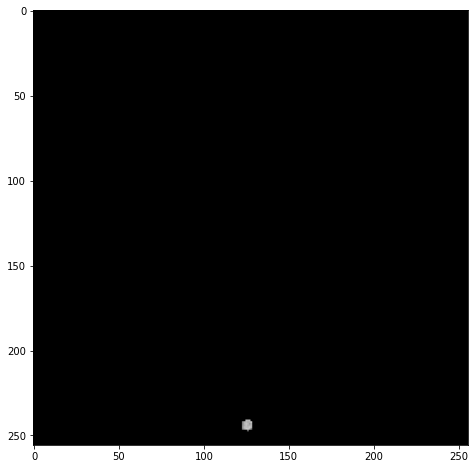

In [88]:
import skimage 

for i in range(mask.shape[2]):
    #temp = skimage.io.imread('sample.jpg')
    temp = dataset.load_image(image_id)
    for j in range(temp.shape[2]):
        temp[:,:,j] = temp[:,:,j] * mask[:,:,i]
    plt.figure(figsize=(8,8))
    plt.imshow(temp)